<a href="https://colab.research.google.com/github/BrajanNieto/stats-prob-py/blob/main/100.%20PilotoAnalysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from google.colab import files
import io
import numpy as np
from scipy.stats import chi2
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import svd
from scipy import stats

Importar Datos

In [2]:
# 1. Sube el archivo
uploaded = files.upload()
file_name = list(uploaded.keys())[0]
print(f"Archivo subido: {file_name}")
df_encuesta = pd.read_excel(io.BytesIO(uploaded[file_name]), sheet_name='Encuesta')


df_encuesta.head()

Saving Encuesta Formato (2).xlsx to Encuesta Formato (2).xlsx
Archivo subido: Encuesta Formato (2).xlsx


,id,Tipo,Nombres,Apellidos,Sexo,Edad (Años),Peso (kg),Altura (cm),A,B,...,E15,A_Total,C_Total,E_Total,A_Clase,A_Global,C_Clase,C_Global,E_Clase,E_Global
0,1,Cono sur,MIGUEL ANGEL,ZUMARAN RIVERA,M,74,65.0,162.0,1,1,...,0,10,5,10,2,Existe riesgo social,3,Deterioro moderado,3,Moderado
1,2,Cono sur,SOFIA,RAMIREZ MARTINES,F,64,57.0,153.0,1,2,...,0,10,4,7,2,Existe riesgo social,2,Deterioro leve,2,Leve
2,3,Cono sur,EMILIA,CHURA CHOQUE,F,72,68.0,154.0,2,3,...,0,11,4,9,2,Existe riesgo social,2,Deterioro leve,3,Moderado
3,4,Cono sur,GUSTAVO,ZUMARAN RIVERA,M,74,68.0,160.0,1,1,...,0,10,3,6,2,Existe riesgo social,2,Deterioro leve,2,Leve
4,5,Cono sur,MANUELA,CACERES PEREA,F,85,46.0,148.0,1,1,...,1,13,7,10,2,Existe riesgo social,3,Deterioro moderado,3,Moderado


# Análisis del Piloto

In [3]:
df_piloto = df_encuesta[df_encuesta['Tipo'] == 'Piloto']
print("Descripción estadística de df_piloto:")
print(df_piloto.describe(include='all'))

Descripción estadística de df_piloto:
               id    Tipo Nombres     Apellidos Sexo  Edad (Años)   Peso (kg)  \
count   29.000000      29      29            29   29    29.000000   29.000000   
unique        NaN       1      25            29    2          NaN         NaN   
top           NaN  Piloto   LUCIA  ARIAS JALIRE    F          NaN         NaN   
freq          NaN      29       2             1   27          NaN         NaN   
mean    15.310345     NaN     NaN           NaN  NaN    69.931034   65.439655   
std      8.896642     NaN     NaN           NaN  NaN     5.463718   12.107232   
min      1.000000     NaN     NaN           NaN  NaN    60.000000   49.000000   
25%      8.000000     NaN     NaN           NaN  NaN    66.000000   56.000000   
50%     15.000000     NaN     NaN           NaN  NaN    70.000000   65.000000   
75%     23.000000     NaN     NaN           NaN  NaN    73.000000   70.000000   
max     30.000000     NaN     NaN           NaN  NaN    83.000000  100.

In [4]:
print("\nNulos por columna en df_piloto:")
print(df_piloto.isnull().sum())


Nulos por columna en df_piloto:
id           0
Tipo         0
Nombres      0
Apellidos    0
Sexo         0
            ..
A_Global     0
C_Clase      0
C_Global     0
E_Clase      0
E_Global     0
Length: 72, dtype: int64


In [5]:
print("\nColumnas de df_piloto:")
print(", ".join(df_piloto.columns))


Columnas de df_piloto:
id, Tipo, Nombres, Apellidos, Sexo, Edad (Años), Peso (kg), Altura (cm), A, B, C, D, E, F, G, H, I, J, K, L, M, N, O, P, Q, R, Cribaje, Evaluación, Global, Cribaje_Clase, Cribaje_Descripción, Evaluación_Clase, Evaluación_Descripción, A1, A2, A3, A4, A5, C1, C2, C3, C4, C5, C6, C7, C8, C9, C10, E1, E2, E3, E4, E5, E6, E7, E8, E9, E10, E11, E12, E13, E14, E15, A_Total, C_Total, E_Total, A_Clase, A_Global, C_Clase, C_Global, E_Clase, E_Global


## Validación del Constructo

### Bartlett

In [6]:
# ─────────────────────────────────────────────
# 1.  Test de esfericidad de Bartlett
# ─────────────────────────────────────────────
def bartlett_sphericity(df: pd.DataFrame,
                        items: list[str],
                        *,
                        verbose: bool = True):
    """
    χ² de Bartlett para una lista de ítems.
    --------------------------------------
    Retorna: (chi_cuadrado, grados_libertad, p_valor, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Bartlett] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Estadístico de Bartlett
    det_R = np.linalg.det(R)
    if det_R <= 0:
        raise ValueError("Determinante ≤ 0: matriz singular o no positiva definida.")
    chi_square = -(n - 1 - (2 * p + 5) / 6) * np.log(det_R)
    dof = p * (p - 1) / 2
    p_val = 1 - chi2.cdf(chi_square, dof)

    return chi_square, dof, p_val, const_cols


### KMO

In [7]:
# ─────────────────────────────────────────────
# 2.  Índice KMO global e individual
# ─────────────────────────────────────────────
def kmo_test(df: pd.DataFrame,
             items: list[str],
             *,
             verbose: bool = True):
    """
    KMO global y por ítem.
    ----------------------
    Retorna: (kmo_global, serie_kmo_individual, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[KMO] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")
    if n <= p:
        raise ValueError("n ≤ p: la matriz de correlaciones no es invertible.")

    # 2. Matriz de correlaciones
    R = data.corr()

    # 3. Matriz de correlaciones parciales
    inv_R = np.linalg.inv(R)
    partial = -inv_R / np.sqrt(np.outer(np.diag(inv_R), np.diag(inv_R)))
    np.fill_diagonal(partial, 0)

    # 4. KMO global
    corr_sq = (R.values[np.triu_indices(p, 1)] ** 2).sum()
    part_sq = (partial[np.triu_indices(p, 1)] ** 2).sum()
    kmo_global = corr_sq / (corr_sq + part_sq)

    # 5. KMO por ítem
    kmo_individual = {}
    for i, col in enumerate(R.columns):
        corr_sq_i = (R.iloc[i, :].drop(index=col) ** 2).sum()
        part_sq_i = (partial[i, :] ** 2).sum()
        kmo_individual[col] = corr_sq_i / (corr_sq_i + part_sq_i)

    kmo_series = pd.Series(kmo_individual, name="KMO_individual")

    return kmo_global, kmo_series, const_cols

In [8]:
# ─────────────────────────────────────────────
# 3.  Alfa de Cronbach
# ─────────────────────────────────────────────
def cronbach_alpha(df: pd.DataFrame,
                   items: list[str],
                   *,
                   verbose: bool = True):
    """
    Alfa de Cronbach global y por ítem (α-if-deleted).
    --------------------------------------------------
    Retorna: (alpha_global, serie_alpha_if_deleted, const_cols_eliminadas)
    """
    data = df[items].astype(float).dropna()

    # 1. Quitar columnas constantes
    const_cols = data.columns[data.nunique() == 1].tolist()
    if const_cols and verbose:
        print(f"[Cronbach] Columnas constantes eliminadas: {const_cols}")
    data = data.drop(columns=const_cols)

    n, p = data.shape
    if p < 2:
        raise ValueError("Quedaron <2 ítems tras eliminar constantes.")

    # 2. Alfa global
    item_vars = data.var(ddof=1)
    total_score = data.sum(axis=1)
    total_var = total_score.var(ddof=1)
    if total_var == 0:
        raise ValueError("Varianza total = 0: los ítems suman un valor constante.")
    alpha_global = (p / (p - 1)) * (1 - item_vars.sum() / total_var)

    # 3. Alfa si se elimina cada ítem
    alpha_if_deleted = {}
    for col in data.columns:
        remaining = data.drop(columns=[col])
        p_rem = p - 1
        item_vars_rem = remaining.var(ddof=1)
        total_score_rem = remaining.sum(axis=1)
        total_var_rem = total_score_rem.var(ddof=1)
        if total_var_rem == 0:
            alpha_if_deleted[col] = np.nan
        else:
            alpha_if_deleted[col] = (p_rem / (p_rem - 1)) * (
                1 - item_vars_rem.sum() / total_var_rem
            )

    alpha_series = pd.Series(alpha_if_deleted, name="alpha_if_deleted")

    return alpha_global, alpha_series, const_cols

### Analisis del constructo

In [9]:
# Definición de ítems para cada escala
vdependiente1_cols = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R']
vindependiente1_cols = ['A1','A2','A3','A4','A5']
vindependiente2_cols = ['C1','C2','C3','C4','C5','C6','C7','C8','C9','C10']
vindependiente3_cols = ['E1','E2','E3','E4','E5','E6','E7','E8','E9','E10','E11','E12','E13','E14','E15']

# 1. Variable dependiente (Estado nutricional)
print("Análisis del constructo /n")

print("Variable dependiente /n")
chi2_dv, dof_dv, p_b_dv, const_b_dv = bartlett_sphericity(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Bartlett χ²({int(dof_dv)}) = {chi2_dv:.2f}, p = {p_b_dv:.5e}")
kmo_g_dv, kmo_i_dv, const_k_dv = kmo_test(df_piloto, vdependiente1_cols)
print(f"[Dependiente] KMO global = {kmo_g_dv:.3f}")
print("[Dependiente] KMO individual:")
print(kmo_i_dv.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vdependiente1_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

print("Variable independiente /n")

print('Analisis del Factor sociofamiliar – Escala de Gijón')

# 2. Independiente 1 (Factor sociofamiliar – Escala de Gijón)
chi2_i1, dof_i1, p_b_i1, const_b_i1 = bartlett_sphericity(df_piloto, vindependiente1_cols)
print(f"[Indep1] Bartlett χ²({int(dof_i1)}) = {chi2_i1:.2f}, p = {p_b_i1:.5e}")
kmo_g_i1, kmo_i_i1, const_k_i1 = kmo_test(df_piloto, vindependiente1_cols)
print(f"[Indep1] KMO global = {kmo_g_i1:.3f}")
print("[Indep1] KMO individual:")
print(kmo_i_i1.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente1_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

print('Analisis del  Estado cognitivo – SPMSQ')

# 3. Independiente 2 (Estado cognitivo – SPMSQ)
chi2_i2, dof_i2, p_b_i2, const_b_i2 = bartlett_sphericity(df_piloto, vindependiente2_cols)
print(f"[Indep2] Bartlett χ²({int(dof_i2)}) = {chi2_i2:.2f}, p = {p_b_i2:.5e}")
kmo_g_i2, kmo_i_i2, const_k_i2 = kmo_test(df_piloto, vindependiente2_cols)
print(f"[Indep2] KMO global = {kmo_g_i2:.3f}")
print("[Indep2] KMO individual:")
print(kmo_i_i2.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente2_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))





print('Analisis del Escala de depresión – Yesavag')

# 4. Independiente 3 (Escala de depresión – Yesavage)
chi2_i3, dof_i3, p_b_i3, const_b_i3 = bartlett_sphericity(df_piloto, vindependiente3_cols)
print(f"[Indep3] Bartlett χ²({int(dof_i3)}) = {chi2_i3:.2f}, p = {p_b_i3:.5e}")
kmo_g_i3, kmo_i_i3, const_k_i3 = kmo_test(df_piloto, vindependiente3_cols)
print(f"[Indep3] KMO global = {kmo_g_i3:.3f}")
print("[Indep3] KMO individual:")
print(kmo_i_i3.round(3))
# — Alfa de Cronbach
alpha_dv, alpha_if_del_dv, const_a_dv = cronbach_alpha(df_piloto, vindependiente3_cols)
print(f"[Dependiente] Cronbach α = {alpha_dv:.3f}")
print("[Dependiente] α si se elimina el ítem:")
print(alpha_if_del_dv.round(3))

Análisis del constructo /n
Variable dependiente /n
[Bartlett] Columnas constantes eliminadas: ['G', 'I', 'Q']
[Dependiente] Bartlett χ²(105) = 272.14, p = 1.11022e-16
[KMO] Columnas constantes eliminadas: ['G', 'I', 'Q']
[Dependiente] KMO global = 0.448
[Dependiente] KMO individual:
A    0.799
B    0.760
C    0.443
D    0.733
E    0.485
F    0.288
H    0.304
J    0.395
K    0.611
L    0.215
M    0.367
N    0.425
O    0.758
P    0.241
R    0.166
Name: KMO_individual, dtype: float64
[Cronbach] Columnas constantes eliminadas: ['G', 'I', 'Q']
[Dependiente] Cronbach α = 0.768
[Dependiente] α si se elimina el ítem:
A    0.725
B    0.725
C    0.794
D    0.748
E    0.750
F    0.783
H    0.748
J    0.731
K    0.730
L    0.772
M    0.759
N    0.761
O    0.713
P    0.773
R    0.783
Name: alpha_if_deleted, dtype: float64
Variable independiente /n
Analisis del Factor sociofamiliar – Escala de Gijón
[Indep1] Bartlett χ²(10) = 14.21, p = 1.63563e-01
[Indep1] KMO global = 0.472
[Indep1] KMO individual

In [10]:

def varimax(loadings, gamma=1.0, q=20, tol=1e-6):
    R = np.eye(loadings.shape[1])
    for _ in range(q):
        lam = loadings @ R
        u, _, v = svd(loadings.T @ (lam**3 - (gamma / loadings.shape[0]) *
                                    lam @ np.diag(np.sum(lam**2, axis=0))))
        R_new = u @ v
        if np.max(np.abs(R - R_new)) < tol:
            break
        R = R_new
    return loadings @ R, R

def pca_report(df, cols, variance_threshold=0.80, rotate=True, random_state=None):
    X = df[cols].copy()

    # 1. Quitar columnas constantes y filas con NA
    const_cols = X.columns[X.nunique() <= 1].tolist()
    if const_cols:
        print(f"[PCA] columnas constantes eliminadas: {const_cols}")
        X = X.drop(columns=const_cols)
    X = X.dropna()

    # 2. Estandarizar
    scaler = StandardScaler()
    X_std = scaler.fit_transform(X)

    # 3. PCA con todas las comp.
    pca_full = PCA(random_state=random_state).fit(X_std)
    eigval = pca_full.explained_variance_
    ratio = pca_full.explained_variance_ratio_
    cum_ratio = ratio.cumsum()

    eig_df = (pd.DataFrame({"Autovalor": eigval,
                            "% Var.Exp": ratio,
                            "% Var.Acum": cum_ratio})
              .assign(Componente=lambda d: np.arange(1, len(d)+1))
              .set_index("Componente"))

    # 4. Scree plot
    plt.figure()
    plt.plot(eig_df.index, eig_df["Autovalor"], marker="o")
    plt.axhline(1, ls="--")
    plt.xlabel("Componente"); plt.ylabel("Autovalor")
    plt.title("Scree plot")
    plt.show()

    # 5. Nº de componentes
    n_ret = max(1, (cum_ratio <= variance_threshold).sum())
    print(f"[PCA] Componentes retenidas: {n_ret} "
          f"({cum_ratio[n_ret-1]:.2%} var. acumulada)")

    # 6. PCA restringido
    pca = PCA(n_components=n_ret, random_state=random_state).fit(X_std)

    # --> Cargas (variables × componentes)
    loadings = pd.DataFrame(pca.components_.T * np.sqrt(pca.explained_variance_),
                            index=X.columns,
                            columns=[f"PC{i+1}" for i in range(n_ret)])

    # 7. Rotación opcional
    loadings_rot = None
    if rotate and n_ret > 1:
        Lrot, _ = varimax(loadings.values)
        loadings_rot = pd.DataFrame(Lrot,
                                    index=loadings.index,
                                    columns=loadings.columns)
        load_plot = loadings_rot
    else:
        load_plot = loadings

    # 8. Heat-map de cargas
    plt.figure(figsize=(1.2*n_ret, 0.5*len(load_plot)))
    plt.imshow(load_plot, aspect="auto")
    plt.xticks(range(n_ret), load_plot.columns)
    plt.yticks(range(len(load_plot)), load_plot.index)
    plt.colorbar(label="Carga")
    plt.title("Cargas" + (" (rotadas)" if rotate and n_ret > 1 else ""))
    plt.show()

    # 9. Tabla de varianza (estilo SPSS)
    var_tbl = eig_df.iloc[:n_ret].copy()
    var_tbl[["% Var.Exp", "% Var.Acum"]] *= 100
    print("\n[Matriz total de varianza explicada]\n")
    display(var_tbl.round(2))

    # 10. Comunalidades
    communal = (load_plot**2).sum(axis=1).to_frame("Comunalidad")
    print("\n[Comunalidades]\n")
    display(communal.round(3))

    # 11. Matriz de componentes
    print("\n[Matriz de componentes]\n")
    display(load_plot.round(3))

    return {"eigenvalues": eig_df,
            "loadings": loadings,
            "loadings_rot": loadings_rot,
            "communalities": communal,
            "components_retained": n_ret}

# Ejemplo:
# info = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)


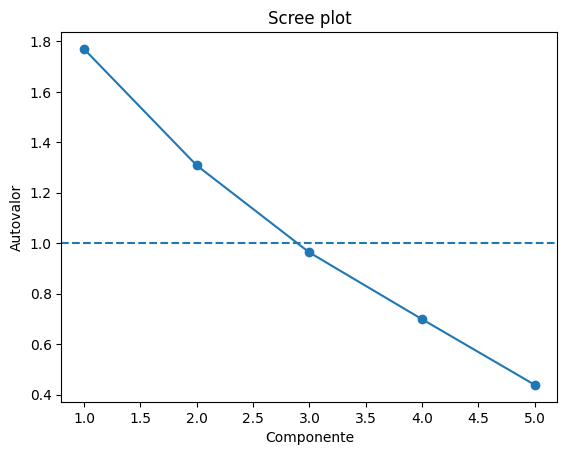

[PCA] Componentes retenidas: 3 (78.06% var. acumulada)


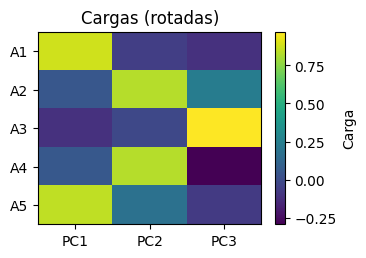


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,1.77,34.19,34.19
2,1.31,25.27,59.46
3,0.96,18.60,78.06



[Comunalidades]



,Comunalidad
A1,0.792
A2,0.751
A3,0.957
A4,0.782
A5,0.760



[Matriz de componentes]



,PC1,PC2,PC3
A1,0.880,-0.061,-0.116
A2,0.049,0.832,0.239
A3,-0.112,-0.020,0.972
A4,0.054,0.832,-0.294
A5,0.850,0.178,-0.077


In [11]:
info = pca_report(df_piloto, vindependiente1_cols, variance_threshold=0.80)

[PCA] columnas constantes eliminadas: ['C5']


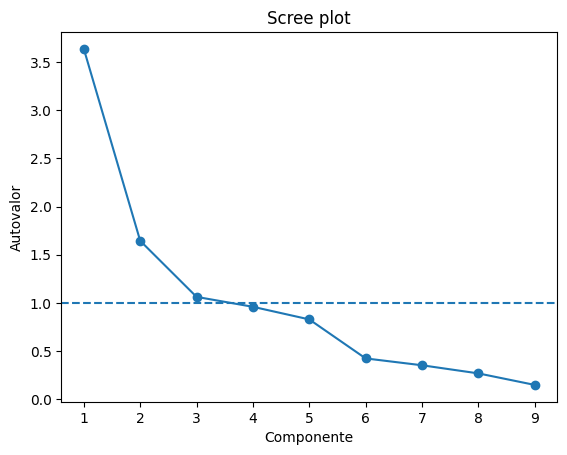

[PCA] Componentes retenidas: 4 (78.36% var. acumulada)


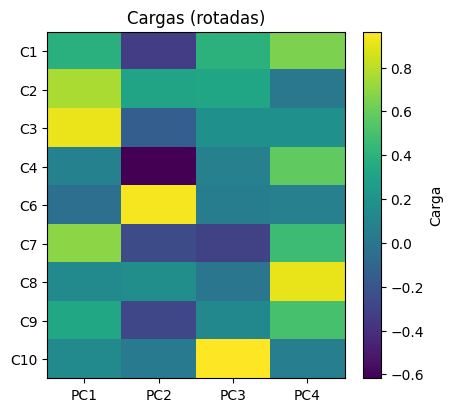


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,3.64,39.03,39.03
2,1.64,17.65,56.67
3,1.06,11.40,68.07
4,0.96,10.29,78.36



[Comunalidades]



,Comunalidad
C1,0.839
C2,0.778
C3,0.930
C4,0.725
C6,0.898
C7,0.852
C8,0.874
C9,0.457
C10,0.951



[Matriz de componentes]



,PC1,PC2,PC3,PC4
C1,0.385,-0.328,0.395,0.653
C2,0.766,0.305,0.314,0.013
C3,0.920,-0.146,0.175,0.178
C4,0.080,-0.618,0.072,0.576
C6,-0.042,0.943,0.050,0.068
C7,0.688,-0.254,-0.309,0.468
C8,0.134,0.165,0.001,0.911
C9,0.329,-0.280,0.120,0.506
C10,0.137,0.029,0.963,0.060


In [12]:
 info2 = pca_report(df_piloto, vindependiente2_cols, variance_threshold=0.80)

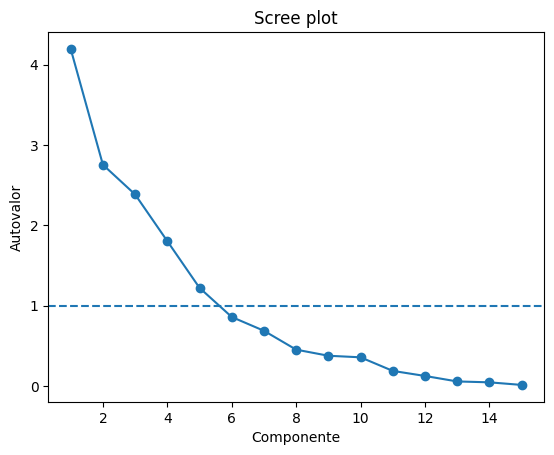

[PCA] Componentes retenidas: 5 (79.54% var. acumulada)


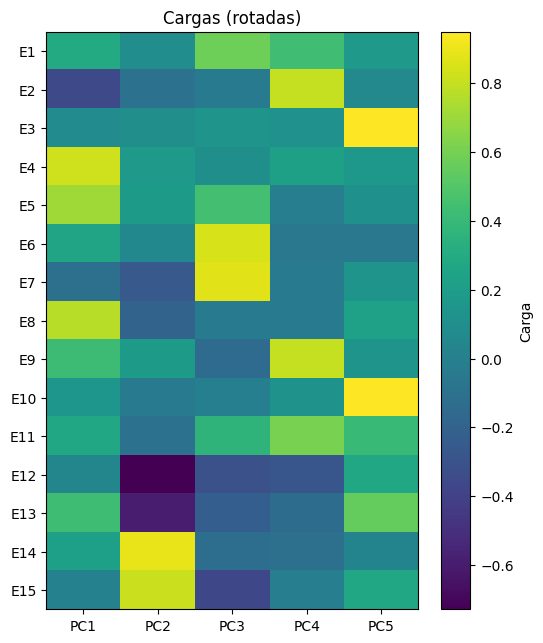


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,4.19,27.00,27.00
2,2.75,17.72,44.72
3,2.38,15.35,60.07
4,1.80,11.61,71.67
5,1.22,7.87,79.54



[Comunalidades]



,Comunalidad
E1,0.648
E2,0.783
E3,0.955
E4,0.812
E5,0.761
E6,0.798
E7,0.869
E8,0.688
E9,0.896
E10,0.936



[Matriz de componentes]



,PC1,PC2,PC3,PC4,PC5
E1,0.295,0.091,0.577,0.433,0.179
E2,-0.359,-0.095,-0.033,0.800,0.062
E3,0.083,0.101,0.141,0.123,0.950
E4,0.831,0.176,0.107,0.224,0.169
E5,0.713,0.189,0.452,-0.010,0.114
E6,0.254,0.056,0.850,-0.057,-0.058
E7,-0.112,-0.262,0.876,-0.032,0.138
E8,0.769,-0.197,-0.042,-0.034,0.233
E9,0.425,0.183,-0.141,0.802,0.138
E10,0.155,-0.046,-0.004,0.129,0.945


In [13]:
 info2 = pca_report(df_piloto, vindependiente3_cols, variance_threshold=0.80)

[PCA] columnas constantes eliminadas: ['G', 'I', 'Q']


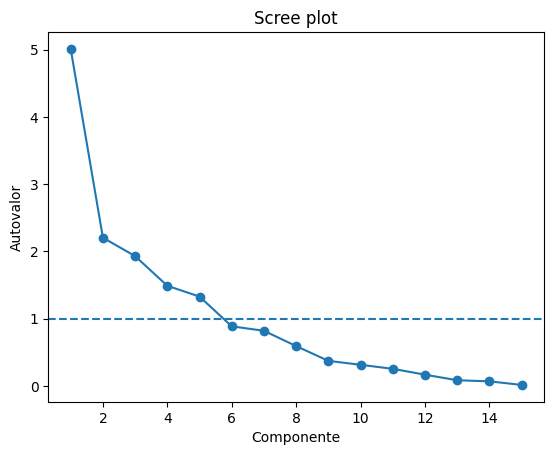

[PCA] Componentes retenidas: 5 (76.99% var. acumulada)


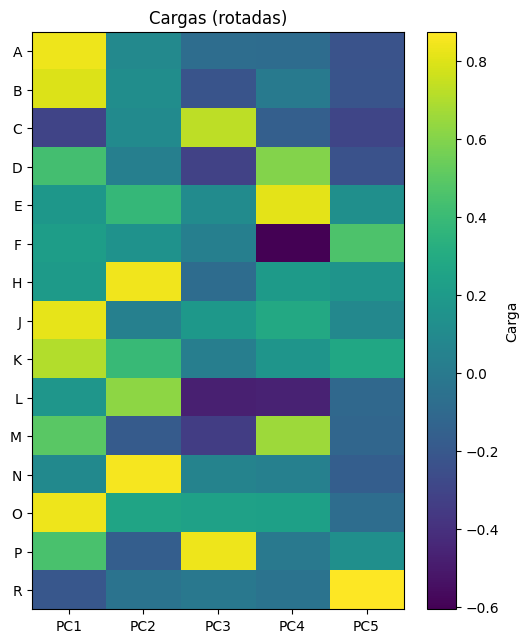


[Matriz total de varianza explicada]



,Autovalor,% Var.Exp,% Var.Acum
Componente,,,
1,5.01,32.25,32.25
2,2.20,14.19,46.43
3,1.93,12.42,58.86
4,1.49,9.58,68.44
5,1.33,8.55,76.99



[Comunalidades]



,Comunalidad
A,0.773
B,0.742
C,0.739
D,0.699
E,0.868
F,0.653
H,0.819
J,0.795
K,0.755
L,0.872



[Matriz de componentes]



,PC1,PC2,PC3,PC4,PC5
A,0.837,0.092,-0.075,-0.083,-0.227
B,0.794,0.119,-0.220,0.001,-0.220
C,-0.302,0.103,0.724,-0.157,-0.296
D,0.430,0.032,-0.313,0.601,-0.232
E,0.180,0.379,0.108,0.815,0.129
F,0.216,0.149,0.034,-0.606,0.464
H,0.202,0.840,-0.084,0.198,0.160
J,0.820,0.040,0.181,0.285,0.083
K,0.706,0.391,0.028,0.163,0.277
L,0.170,0.623,-0.476,-0.467,-0.105


In [ ]:
 info2 = pca_report(df_piloto, vdependiente1_cols, variance_threshold=0.80)

In [14]:
def spearman_test(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    """
    Calcula la correlación de Spearman entre dos columnas y devuelve:
      • rho                    – coeficiente de Spearman
      • se_asymptotic          – error estándar asintótico
      • t_approx               – estadístico t aproximado (rho / se)
      • pvalue                 – significancia aproximada (dos colas)
      • reject_H0              – True si p < alpha, False en caso contrario

    Parámetros
    ----------
    df : DataFrame con los datos
    col_x, col_y : nombres de las columnas a comparar
    alpha : nivel de significancia (p. ej. 0.05)
    as_ordinal :
        - False (default) → usa los valores numéricos tal cual.
        - True  → trata las columnas como ordinales;
                  si son categóricas las convierte a códigos ordenados.
    """
    # Extraer columnas y eliminar nulos simultáneos
    x = df[col_x]
    y = df[col_y]
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    # Si se solicita tratamiento ordinal, convertir a códigos ordenados
    if as_ordinal:
        if pd.api.types.is_categorical_dtype(x):
            x = x.cat.codes
        else:
            x = pd.Categorical(x, ordered=True).codes
        if pd.api.types.is_categorical_dtype(y):
            y = y.cat.codes
        else:
            y = pd.Categorical(y, ordered=True).codes

    n = len(x)
    if n < 3:
        raise ValueError("Se necesitan al menos 3 casos sin NA para Spearman.")

    # Correlación y p-value con SciPy
    rho, p = stats.spearmanr(x, y)

    # Error estándar asintótico (apx. grande-muestra)
    se = 1 / np.sqrt(n - 1)          # ≈√Var(rs)   (Kendall, 1948)

    # Estadístico t aproximado
    t_stat = rho / se                # bajo H0 ~ Normal(0,1) para n grande

    return {
        "rho": rho,
        "se_asymptotic": se,
        "t_approx": t_stat,
        "pvalue": p,
        "reject_H0": p < alpha
    }

In [15]:
df_encuesta_final = df_encuesta[df_encuesta['Tipo'] != 'Piloto']


In [16]:
resultado = spearman_test(
    df=df_encuesta_final,
    col_x="Global",
    col_y="E_Global",
    alpha=0.05,          # Nivel de significancia deseado
    as_ordinal=False     # Pon True si las dos columnas son ordinales
)

print(resultado)


{'rho': np.float64(-0.047018534005683794), 'se_asymptotic': np.float64(0.11785113019775793), 't_approx': np.float64(-0.3989654908424315), 'pvalue': np.float64(0.692834469834937), 'reject_H0': np.False_}


In [17]:
def spearman_test(
        df: pd.DataFrame,
        col_x: str,
        col_y: str,
        alpha: float = 0.05,
        as_ordinal: bool = False
    ) -> dict:
    x = df[col_x]
    y = df[col_y]
    mask = x.notna() & y.notna()
    x, y = x[mask], y[mask]

    if as_ordinal:
        x = pd.Categorical(x, ordered=True).codes
        y = pd.Categorical(y, ordered=True).codes

    n = len(x)
    if n < 3:
        raise ValueError("Se requieren al menos 3 observaciones pareadas.")

    rho, p = stats.spearmanr(x, y)
    se = 1 / np.sqrt(n - 1)
    t_stat = rho / se

    return {
        "rho": rho,
        "se_asymptotic": se,
        "t_approx": t_stat,
        "pvalue": p,
        "reject_H0": p < alpha,
        "n": n          # <= ESTA CLAVE ES LA QUE FALTABA
    }


In [18]:
# -------------------------------------------------------------
# Pares de columnas a comparar
# -------------------------------------------------------------
alpha = 0.05      # nivel de significancia

# Versión numérica
numeric_pairs = [
    ("Global",        "A_Total"),   # Estado Nutricional vs Factor sociofamiliar
    ("Global",        "C_Total"),   # Estado Nutricional vs Estado cognitivo
    ("Global",        "E_Total")    # Estado Nutricional vs Depresión
]

# Versión de clase (ordinal)
class_pairs = [
    ("Evaluación_Clase", "A_Clase"),   # Evaluación_Clase vs Factor sociofamiliar (clase)
    ("Evaluación_Clase", "C_Clase"),   # Evaluación_Clase vs Estado cognitivo (clase)
    ("Evaluación_Clase", "E_Clase")    # Evaluación_Clase vs Depresión (clase)
]

# -------------------------------------------------------------
# Función auxiliar para imprimir resultados
# -------------------------------------------------------------
def print_result(dep, indep, res, tipo):
    decision = (
        "HAY relación y SE RECHAZA H₀"
        if res["reject_H0"] else
        "NO hay relación (no se rechaza H₀)"
    )
    print(
        f"[{tipo}] {dep} ~ {indep} | "
        f"n={res['n']:>3} | ρₛ={res['rho']:+.3f} | "
        f"p={res['pvalue']:.4f} -> {decision}"
    )

# -------------------------------------------------------------
# Ejecutar análisis
# -------------------------------------------------------------
for dep, indep in numeric_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=False)
        print_result(dep, indep, res, "Numérico")
    else:
        print(f"[Numérico] Columnas no encontradas: {dep} y/o {indep}")

print("-" * 80)

for dep, indep in class_pairs:
    if dep in df_encuesta_final.columns and indep in df_encuesta_final.columns:
        res = spearman_test(df_encuesta_final, indep, dep, alpha=alpha, as_ordinal=True)
        print_result(dep, indep, res, "Clase (ordinal)")
    else:
        print(f"[Clase] Columnas no encontradas: {dep} y/o {indep}")

[Numérico] Global ~ A_Total | n= 73 | ρₛ=-0.476 | p=0.0000 -> HAY relación y SE RECHAZA H₀
[Numérico] Global ~ C_Total | n= 73 | ρₛ=-0.434 | p=0.0001 -> HAY relación y SE RECHAZA H₀
[Numérico] Global ~ E_Total | n= 73 | ρₛ=-0.322 | p=0.0055 -> HAY relación y SE RECHAZA H₀
--------------------------------------------------------------------------------
[Clase (ordinal)] Evaluación_Clase ~ A_Clase | n= 73 | ρₛ=-0.308 | p=0.0081 -> HAY relación y SE RECHAZA H₀
[Clase (ordinal)] Evaluación_Clase ~ C_Clase | n= 73 | ρₛ=-0.368 | p=0.0014 -> HAY relación y SE RECHAZA H₀
[Clase (ordinal)] Evaluación_Clase ~ E_Clase | n= 73 | ρₛ=-0.191 | p=0.1048 -> NO hay relación (no se rechaza H₀)


In [22]:
import pandas as pd
from scipy.stats import shapiro




# 3. Variables a evaluar
variables = ['Global', 'A_Total', 'C_Total', 'E_Total']

# 4. Ejecuta Shapiro–Wilk
results = []
for var in variables:
    datos = df_encuesta_final[var].dropna()
    W, p = shapiro(datos)
    results.append({
        'variable': var,
        'W_stat': round(W, 4),
        'p_value': round(p, 4),
        'normal? (p > 0.05)': p > 0.05
    })

# 5. Muestra la tabla
print(pd.DataFrame(results))


  variable  W_stat  p_value  normal? (p > 0.05)
0   Global  0.9756   0.1672                True
1  A_Total  0.9447   0.0030               False
2  C_Total  0.9368   0.0012               False
3  E_Total  0.9466   0.0038               False
